<a href="https://colab.research.google.com/github/tygerlord/le-probleme-sat/blob/main/le_piege_de_grover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Le piège de Grover

Lors de mes déambulations sur le net, je suis tombé sur le blog de 'Balise' décrivant [le problème SAT](https://blog.pasithee.fr/2013/02/25/le-probleme-sat/) et comme je trifouillais également dans le quantique à ce moment là, je me suis mis en tête de résoudre l'exemple donné dans le blog de Balise par une méthode quantique.  

<br>

J'ai donc commencé par reproduire la fonction d'exemple composée de portes logiques avec des portes quantiques, j'ai mis au four (200°C, 1ms) et impécablement reproduit la table de vérité attendue. Bien sûre, aucune accélération quantique avec ce procédé. J'ai donc voulu aller plus loin, et toucher du doigt cette puissance de calcul miraculeuse promise en utilisant l'algorithme de [Grover](https://en.wikipedia.org/wiki/Grover%27s_algorithm), Et là patatrac, je suis tombé sur un os, ça ne marchait pas. Evidemment je ne pouvais qu'avoir fait une erreur dans mon implémentation, je refuse de croire que cette puissance de calcul comporte un hic, le graal ne peut pas avoir un petit defaut. J'ai donc torturé les circuits dans tout les sens, rien à faire.  

<br>

C'est le coeur lourd que je me suis résolu a me dire que l'algorithme Grover ne fonctionnait pas dans ce cas, ce qui remettait en question son usage, en effet difficile d'imaginer utiliser un algorithme qui peut vous dire qu'il n'y a pas de solutions alors qu'au contraire le problème en comporte plusieurs. 
Heureusement après réflexion, j'ai constaté qu'il y avait des moyens simples de contourner le problème et ainsi d'avoir la certitude d'un fonctionnement correcte dans tout les cas.  

<br>

Avant de détailler ma mésaventure, je vous conseille pour ceux qui veulent aborder ce monde plein de promesses de la quantique d'aller visiter [Quantum : Un peu de mathématiques pour l’informatique quantique](https://exo7math.github.io/quantum-exo7/), formidable resource sur le sujet ainsi que l'excellent blog de [Vivien Londe](https://vivienlonde.github.io/blog) et bien sur l'outils [Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html)

<br>

Passons au détail que vous pouvez retrouver en intégralité sur [github]()



In [23]:
!pip install qiskit
!pip install pylatexenc

In [24]:
%matplotlib inline
import qiskit as q

import matplotlib.pyplot as plt

import numpy as np

import math
import operator


# Test circuit

# Préparation

Problème a résoudre

sat-pb.png

réécriture de F ( je n'ai pas trouvé le OU )

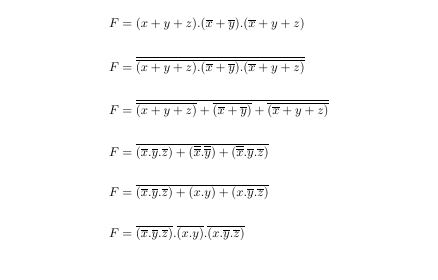


# Construction du circuit



In [25]:


def test():
    circuit = q.QuantumCircuit(10, 4)

    circuit.barrier()
    circuit.h([0,1,2])
    
    circuit.barrier()
    circuit.cx([0,1,2], [3,4,5])

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.mct([3,4,5],6)
    circuit.mct([0,1],7)
    circuit.mct([0,4,5],8)

    circuit.barrier()
    circuit.x([6,7,8])

    circuit.barrier()
    circuit.mct([6,7,8],9)

    circuit.barrier()
    m = range(0,3)
    circuit.measure(m,m)
    circuit.measure(9,3)
    return circuit

circuit = test()

#  Affichage du circuit

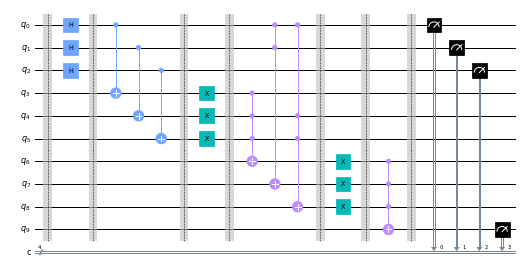

In [26]:
#print(circuit.draw(output='text'))
style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation

Table de vérité de F, résultat attendu.

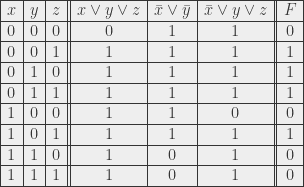

Nombre de '0'et de '1': {'1110': 14, '0001': 10, '1010': 8, '1100': 13, '1101': 8, '0111': 17, '0000': 18, '0011': 12}
{'0000': 18, '0111': 17, '1110': 14, '1100': 13, '0011': 12, '0001': 10, '1010': 8, '1101': 8}


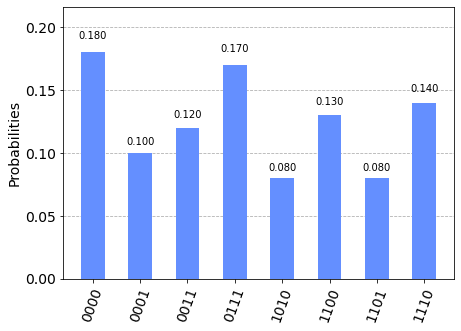

In [27]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')

simulator.set_options(method="matrix_product_state")

job = q.execute(circuit, simulator, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)


Le 4ième bit indique le résultat de F pour les valeurs des 3 premiers bits

ex)
0101 F=1 pour x=0, y=1, z=0



```
XYZF | XYZ | F
--------------
0101 | 010 | 1
0011 | 001 | 1
1011 | 101 | 1
0111 | 011 | 1
```

On retrouve nos 4 solutions du tableau précédent

Par contre question performance, tel quel, on y gagne rien du tout niveau complexité de l'algorithme, pire, on dégrade puisque expériementalement il faut au moins 16 boucles alors que, en version classique, il y a 8 combinaisons à tester. 

Il y a une dimension dans notre circuit que nous n'avons pas utilisé, les probabilités.


# Utilisation des propriétés quantiques

Pour aller plus loin il faut réussir à utiliser les propriétés quantiques afin d'orienter la ou les solution(s) vers une plus forte probabilité en utilisant l'algorithme de [Grover](https://en.wikipedia.org/wiki/Grover%27s_algorithm). 



# Construction du circuit 2

Utilisation de l'algorithme de Grover. La documentation de [Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html) fournit un exemple et des explications complètes sur cet algorithme.




In [28]:

def diffuser(nqubits):
    qc = q.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

var_qubits = q.QuantumRegister(3, name='v')
clause_qubits = q.QuantumRegister(6, name='c')
output_qubit = q.QuantumRegister(1, name='out')
cbits = q.ClassicalRegister(3, name='cbits')

circuit = q.QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def test2(circuit, var_qubits, clause_qubits, output_bits):

    circuit.cx([0,1,2], [3,4,5])

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.mct([3,4,5],6) 
    circuit.mct([0,1],7)
    circuit.mct([0,4,5],8)

    circuit.barrier()
    circuit.x([6,7,8])

    circuit.mct([6,7,8],9)

    # uncomputation
    circuit.barrier()
    circuit.x([6,7,8])

    circuit.barrier()
    circuit.mct([3,4,5],6) 
    circuit.mct([0,1],7)
    circuit.mct([0,4,5],8)

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.cx([2,1,0], [5,4,3])

 
# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
circuit.h([0,1,2])
circuit.barrier()  # for visual separation

## N Iteration
for i in range(0,1):
    # Apply our oracle
    test2(circuit, var_qubits, clause_qubits, output_qubit)
    circuit.barrier()  # for visual separation

    # Apply our diffuser
    circuit.append(diffuser(3), [0,1,2])


# Measure the variable qubits
circuit.measure(var_qubits, cbits)


#  Affichage du circuit 2

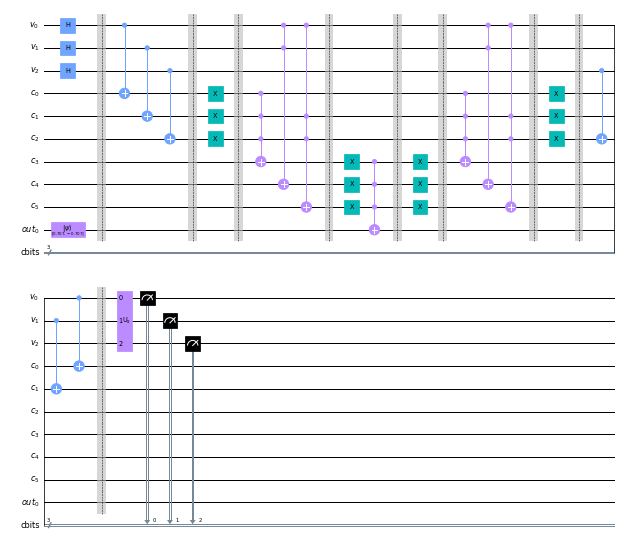

In [29]:

style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation 2


Nombre de '0'et de '1': {'010': 19, '111': 12, '011': 11, '000': 5, '101': 19, '001': 16, '110': 11, '100': 7}
{'010': 19, '101': 19, '001': 16, '111': 12, '011': 11, '110': 11, '100': 7, '000': 5}


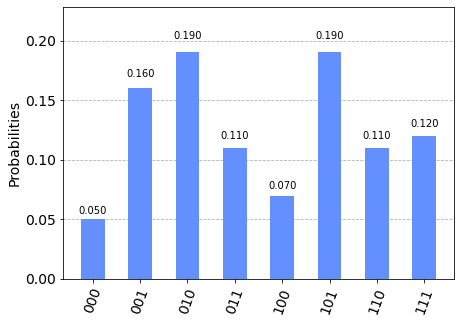

In [30]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')
#simulator = q.Aer.get_backend('aer_simulator')#'qasm_simulator')

simulator.set_options(method="matrix_product_state")


job = q.execute(circuit, simulator, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)


Le résultat est plutôt décevant !  Ces valeurs ne permettent pas de déterminer une solution a notre fonction F alors que nous savons qu'il y en a quatre...

Pour tenter de comprendre ce qui se passe, développons l'algorithme sur 3 fonctions ayant respectivement 3, 4 et 0 solutions.


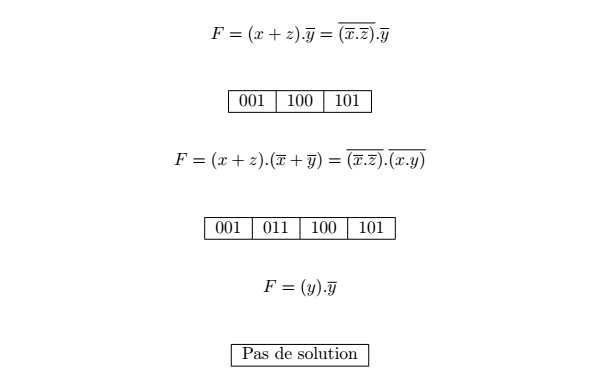

# Construction du circuit (x+z).!y

---





In [31]:

def diffuser(nqubits):
    qc = q.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

var_qubits = q.QuantumRegister(3, name='v')
clause_qubits = q.QuantumRegister(5, name='c')
output_qubit = q.QuantumRegister(1, name='out')
cbits = q.ClassicalRegister(3, name='cbits')

circuit = q.QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def test2(circuit, var_qubits, clause_qubits, output_bits):

    circuit.cx([0,1,2], [3,4,5])

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.mct([3,5],6) 
    circuit.mct([1],7)
 
    circuit.barrier()
    circuit.x([6,7])

    circuit.mct([6,7],8)

    # uncomputation
    circuit.barrier()
    circuit.x([6,7])

    circuit.barrier()
    circuit.mct([3,5],6) 
    circuit.mct([1],7)

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.cx([2,1,0], [5,4,3])

 
# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
circuit.h([0,1,2])
circuit.barrier()  # for visual separation

## N Iteration
for i in range(0,1):
    # Apply our oracle
    test2(circuit, var_qubits, clause_qubits, output_qubit)
    circuit.barrier()  # for visual separation

    # Apply our diffuser
    circuit.append(diffuser(3), [0,1,2])


# Measure the variable qubits
circuit.measure(var_qubits, cbits)


#  Affichage du circuit (x+z).!y

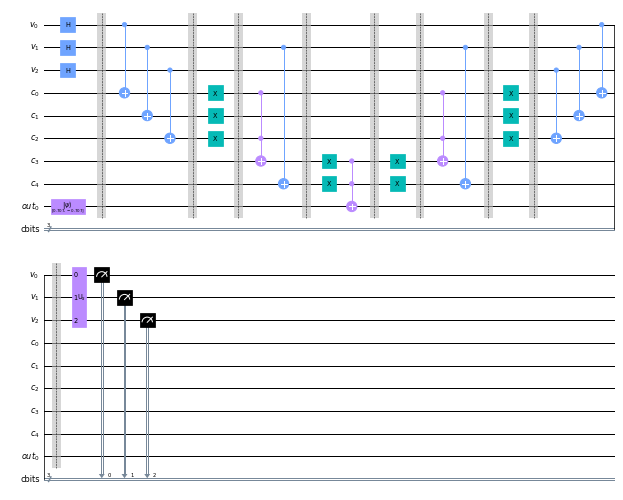

In [32]:

style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation (x+z).!y


Nombre de '0'et de '1': {'001': 296, '101': 290, '000': 26, '011': 31, '111': 38, '100': 282, '110': 34, '010': 27}
{'001': 296, '101': 290, '100': 282, '111': 38, '110': 34, '011': 31, '010': 27, '000': 26}


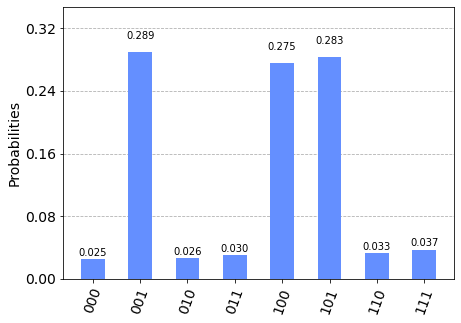

In [33]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')
#simulator = q.Aer.get_backend('aer_simulator')#'qasm_simulator')

simulator.set_options(method="matrix_product_state")


job = q.execute(circuit, simulator)#, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)


Le résultat est conforma à nos attentes, on retrouve bien nos 3 solutions !

# Construction du circuit (x+z).(!x+!y)




In [34]:

def diffuser(nqubits):
    qc = q.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

var_qubits = q.QuantumRegister(3, name='v')
clause_qubits = q.QuantumRegister(5, name='c')
output_qubit = q.QuantumRegister(1, name='out')
cbits = q.ClassicalRegister(3, name='cbits')

circuit = q.QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def test2(circuit, var_qubits, clause_qubits, output_bits):

    circuit.cx([0,1,2], [3,4,5])

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.mct([3,5],6) 
    circuit.mct([0,1],7)
 
    circuit.barrier()
    circuit.x([6,7])

    circuit.mct([6,7],8)

    # uncomputation
    circuit.barrier()
    circuit.x([6,7])

    circuit.barrier()
    circuit.mct([3,5],6) 
    circuit.mct([0,1],7)

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.cx([2,1,0], [5,4,3])

 
# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
circuit.h([0,1,2])
circuit.barrier()  # for visual separation

## N Iteration
for i in range(0,1):
    # Apply our oracle
    test2(circuit, var_qubits, clause_qubits, output_qubit)
    circuit.barrier()  # for visual separation

    # Apply our diffuser
    circuit.append(diffuser(3), [0,1,2])


# Measure the variable qubits
circuit.measure(var_qubits, cbits)


#  Affichage du circuit (x+z).(!x+!y)

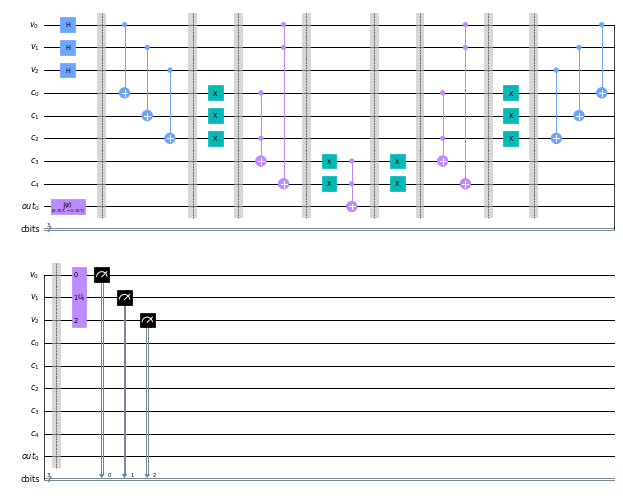

In [35]:

style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation (x+z).(!x+!y)


Nombre de '0'et de '1': {'001': 127, '010': 131, '110': 130, '100': 117, '101': 118, '000': 131, '111': 129, '011': 141}
{'011': 141, '010': 131, '000': 131, '110': 130, '111': 129, '001': 127, '101': 118, '100': 117}


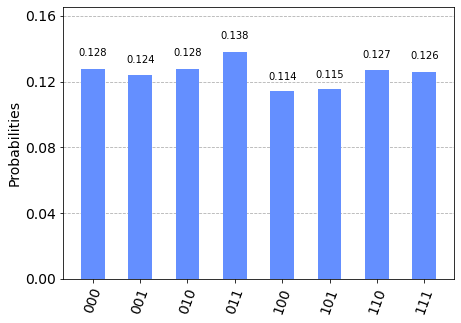

In [36]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')
#simulator = q.Aer.get_backend('aer_simulator')#'qasm_simulator')

simulator.set_options(method="matrix_product_state")


job = q.execute(circuit, simulator)#, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)


Là, il se passe quelque chose qui cloche, nous n'obtenons pas nos 4 solutions.

# Construction du circuit (y).!y


In [37]:

def diffuser(nqubits):
    qc = q.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

var_qubits = q.QuantumRegister(3, name='v')
clause_qubits = q.QuantumRegister(5, name='c')
output_qubit = q.QuantumRegister(1, name='out')
cbits = q.ClassicalRegister(3, name='cbits')

circuit = q.QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def test2(circuit, var_qubits, clause_qubits, output_bits):

    circuit.cx([0,1,2], [3,4,5])

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.mct([4],6) 
    circuit.mct([1],7)
 
    circuit.barrier()
    circuit.x([6,7])

    circuit.mct([6,7],8)

    # uncomputation
    circuit.barrier()
    circuit.x([6,7])

    circuit.barrier()
    circuit.mct([4],6) 
    circuit.mct([1],7)

    circuit.barrier()
    circuit.x([3,4,5])

    circuit.barrier()
    circuit.cx([2,1,0], [5,4,3])

 
# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
circuit.h([0,1,2])
circuit.barrier()  # for visual separation

## N Iteration
for i in range(0,1):
    # Apply our oracle
    test2(circuit, var_qubits, clause_qubits, output_qubit)
    circuit.barrier()  # for visual separation

    # Apply our diffuser
    circuit.append(diffuser(3), [0,1,2])


# Measure the variable qubits
circuit.measure(var_qubits, cbits)


#  Affichage du circuit (y).!y

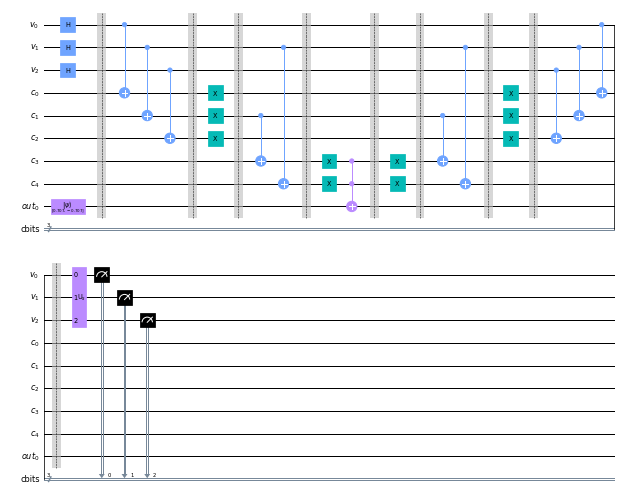

In [38]:

style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation (y).!y


Nombre de '0'et de '1': {'001': 133, '010': 142, '110': 122, '100': 115, '111': 119, '000': 149, '011': 117, '101': 127}
{'000': 149, '010': 142, '001': 133, '101': 127, '110': 122, '111': 119, '011': 117, '100': 115}


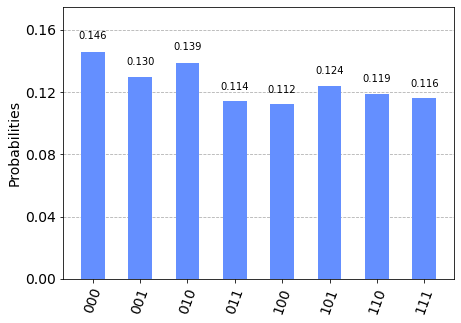

In [39]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')
#simulator = q.Aer.get_backend('aer_simulator')#'qasm_simulator')

simulator.set_options(method="matrix_product_state")


job = q.execute(circuit, simulator)#, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)


Là c'est plutôt conforme à ce qu'on est en droit d'attendre, il n'y a pas de solutions possible.



L'algorithme de Grover semble ne pas fonctionner correctement lorsqu'on a beaucoup de solutions, disons au moins N/2 solutions, on obtient un résultat sensiblement identique à 0 solutions. (Je laisse aux mathématiciens chevronnés le soin de justifier ou non ce comportement de l'algorithme)

Comment éviter cet écueil ?

Si c'est possible, déterminer à l'avance le nombre de solutions et vérifier qu'il soit inférieur à N/2.

Si on peux pas déterminer le nombre de solutions, j'ai envisagé 2 possibilités selon les cas d'usages*

1) On peut, si on tombe sur un cas zéro solution, tester aléatoirement quelques solution, si on est dans un cas de nombreuses solutions on a de bonne chance d'en trouver une. 

2) On peut également ajouter un qubit supplémentaire d'entré et l'intégrer à l'Oracle, ce qui va artificiellement faire monter le nombre de combinaisons et donc faire chuter le nombre de solutions sous (N+1)/2.


# Construction du circuit 3


In [40]:

def diffuser(nqubits):
    qc = q.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

var_qubits = q.QuantumRegister(4, name='v')
clause_qubits = q.QuantumRegister(6, name='c')
output_qubit = q.QuantumRegister(1, name='out')
cbits = q.ClassicalRegister(4, name='cbits')

circuit = q.QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def test2(circuit, var_qubits, clause_qubits, output_bits):

    circuit.cx([0,1,2], [4,5,6])

    circuit.barrier()
    circuit.x([4,5,6])

    circuit.barrier()
    circuit.mct([4,5,6],7) 
    circuit.mct([0,1],8)
    circuit.mct([0,5,6],9)

    circuit.barrier()
    circuit.x([7,8,9])

    circuit.mct([3,7,8,9],10)

    # uncomputation
    circuit.barrier()
    circuit.x([7,8,9])

    circuit.barrier()
    circuit.mct([4,5,6],7) 
    circuit.mct([0,1],8)
    circuit.mct([0,5,6],9)

    circuit.barrier()
    circuit.x([4,5,6])

    circuit.barrier()
    circuit.cx([2,1,0], [6,5,4])

 
# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
circuit.h([0,1,2,3])
circuit.barrier()  # for visual separation

## N Iteration
for i in range(0,1):
    # Apply our oracle
    test2(circuit, var_qubits, clause_qubits, output_qubit)
    circuit.barrier()  # for visual separation

    # Apply our diffuser
    circuit.append(diffuser(4), [0,1,2,3])


# Measure the variable qubits
circuit.measure(var_qubits, cbits)


#  Affichage du circuit 3

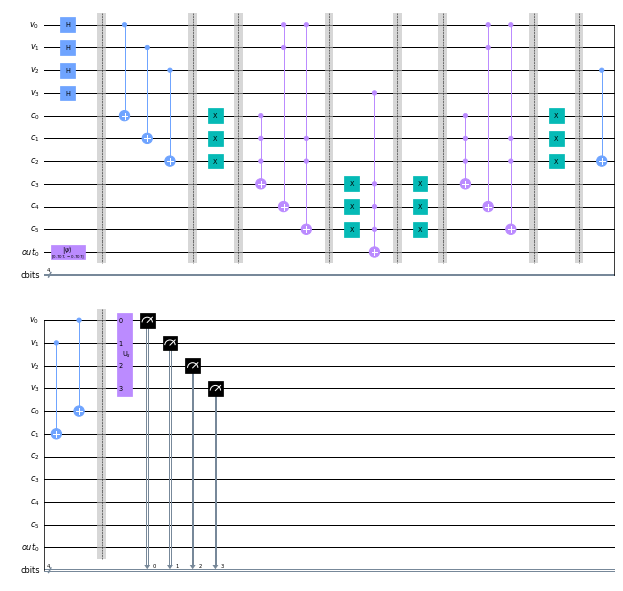

In [41]:

style = { "figwidth" : 50 }
circuit.draw(output='mpl', scale=0.5)#style=style)

# Exécution, Résultats et visualisation 3


Nombre de '0'et de '1': {'1110': 22, '1010': 27, '1100': 27, '1101': 24}
{'1010': 27, '1100': 27, '1101': 24, '1110': 22}


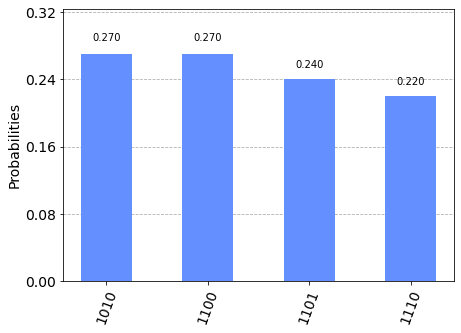

In [42]:
repeat = 100

simulator = q.Aer.get_backend('qasm_simulator')
#simulator = q.Aer.get_backend('aer_simulator')#'qasm_simulator')

simulator.set_options(method="matrix_product_state")


job = q.execute(circuit, simulator, shots=repeat)

result = job.result()

counts = result.get_counts(circuit)
print("Nombre de '0'et de '1':",counts)

sorted_counts = dict( sorted(counts.items(), key=operator.itemgetter(1), reverse=True))
print(sorted_counts)

q.visualization.plot_histogram(counts)



On retrouve bien le résultat de notre fonction F:


```
XYZF | XYZ | F
--------------
0101 | 010 | 1
0011 | 001 | 1
1011 | 101 | 1
0111 | 011 | 1
```






Malgré cet excellent résultat il manque une justification mathématique à tout ceci. De plus en théorie il nous faudrait √(N/M) rotations avec 4 qubits N=16 et 4 solutions M=4 cela fait 2 rotations or le résultat est très bon en une rotation. Il faudra donc étudier plus finement ce qui se passe exactement ainsi que l'impact de ce qubit supplémentaire sur les autres cas. 

In [43]:
import qiskit.tools.jupyter
%qiskit_version_table